# Rose tutorial numerical model


In [6]:
import os
# import pickle for saving results
import pickle
# import ROSE packages
from rose.model.model_part import Material, Section
from rose.model.train_model import *
from rose.model.train_track_interaction import *

<img src="static/train_track_model.png">

# Fill in parameters train

<img src="static/train_model.png">

In [7]:
# set up train
tr = {}
# set up bogie configuration
tr["wheel_distances"] = [-1.25, 1.25]  # wheel distances from the centre of the bogie [m]
tr["bogie_length"] = 2  # length of the bogie [m]

# set up cart configuration
tr["bogie_distances"] = [-10, 10]  # bogie distances from the centre of the cart [m]
tr["cart_length"] = 28  # length of the cart [m]

# set up train configuration
tr["cart_distances"] = [26.55 + 14]  # cart distances from the start of the track [m]

# set train parameters
tr["mass_wheel"] = 1834  # mass of one wheel [kg]
tr["mass_bogie"] = 6e3  # mass of one bogie [kg]
tr["mass_cart"] = 75.5e3  # mass of one cart  [kg]

tr["inertia_bogie"] = 0.31e3  # mass inertia of one bogie   [kg.m2]
tr["inertia_cart"] = 128.8e3  # mass inertia of one cart   [kg.m2]

tr["prim_stiffness"] = 4800e3  # primary suspension: stiffness between wheels and bogie  [N/m]
tr["sec_stiffness"] = 2708e3  # secondary suspension: stiffness between bogies and cart  [N/m]

tr["prim_damping"] = 0.25e3  # primary suspension: damping between wheels and bogie  [N.s/m]
tr["sec_damping"] = 64e3  # secondary suspension: damping between bogies and cart  [N.s/m]

tr["velocity"] = 100/3.6 # set velocity of the train [m/s]


# Set geometry track

<img src="static/track_model.png">

In [8]:
# Set geometry parameters of the track
nb_sleepers_per_segment =[200]#, 100]
geometry = {}
geometry["n_segments"] = len(nb_sleepers_per_segment)  # number of segments
geometry["n_sleepers"] = [n  for n in nb_sleepers_per_segment]  # number of sleepers per segment
geometry["sleeper_distance"] = 0.6  # distance between sleepers, equal for each segment
geometry["depth_soil"] = [1]#, 1]  # depth of the soil [m] per segment

<img src="static/rose_elements.png">

# Fill in parameters track

In [9]:
mat = {}
# set parameters of the rail
mat["young_mod_beam"] = 210e9  # young modulus rail
mat["poisson_beam"] = 0.0  # poison ration rail
mat["inertia_beam"] = 2.24E-05  # inertia of the rail
mat["rho"] = 7860  # density of the rail
mat["rail_area"] = 69.6e-2  # area of the rail
mat["shear_factor_rail"] = 0  # Timoshenko shear factor

# set parameters rail pad
mat["mass_rail_pad"] = 5  # mass of the rail pad [kg]
mat["stiffness_rail_pad"] = 750e6  # stiffness of the rail pad [N/m2]
mat["damping_rail_pad"] = 750e3  # damping of the rail pad [N/m2/s]

# set parameters sleeper
mat["mass_sleeper"] = 140  # [kg]

# Rayleigh damping system
mat["damping_ratio"] = 0.02  # damping
mat["omega_one"] = 6.283  # first radial_frequency
mat["omega_two"] = 125.66  # second radial_frequency

# set up contact parameters
mat["hertzian_contact_coef"] = 9.1e-7  # Hertzian contact coefficient
mat["hertzian_power"] = 3 / 2  # Hertzian power

# Set soil parameters of each segment
soil = {"stiffness_soils": [180e6],
        "damping_soils": [30e3]}


# Fill in time integration

In [10]:
time_int = {}
# set time parameters in two stages
time_int["tot_ini_time"] = 0.5  # total initalisation time  [s]
time_int["n_t_ini"] = 5000  # number of time steps initialisation time  [-]

time_int["tot_calc_time"] = 1.2  # total time during calculation phase   [s]
time_int["n_t_calc"] = 8000  # number of time steps during calculation phase [-]

# Choose solver

In [11]:
# choose solver
import solvers.newmark_solver as newmark_solver
solver = newmark_solver.NewmarkImplicitForce()

# Populate time integration

In [12]:
# set initialisation time
initialisation_time = np.linspace(0, time_int["tot_ini_time"], time_int["n_t_ini"])
# set calculation time
calculation_time = np.linspace(initialisation_time[-1], initialisation_time[-1] + time_int["tot_calc_time"],
                               time_int["n_t_calc"])
# Combine all time steps in an array
time = np.concatenate((initialisation_time, calculation_time[1:]))

# Generate geometry track

In [13]:
all_element_model_parts = []
all_meshes = []
# loop over number of segments
for idx in range(geometry["n_segments"]):
    # set geometry of one segment
    element_model_parts, mesh = create_horizontal_track(geometry["n_sleepers"][idx],
                                                        geometry["sleeper_distance"],
                                                        geometry["depth_soil"][idx])
    # add segment model parts and mesh to list
    all_element_model_parts.append(element_model_parts)
    all_meshes.append(mesh)

# Setup global mesh and combine model parts of all segments
rail_model_part, sleeper_model_part, rail_pad_model_part, soil_model_parts, all_mesh = \
    combine_horizontal_tracks(all_element_model_parts, all_meshes, 0.6)

# Fixate the bottom boundary
bottom_boundaries = [add_no_displacement_boundary_to_bottom(soil_model_part)["bottom_boundary"] for soil_model_part
                     in soil_model_parts]

# constraint rotation at the side boundaries
side_boundaries = ConstraintModelPart(x_disp_dof=False, y_disp_dof=True, z_rot_dof=True)
side_boundaries.nodes = [rail_model_part.nodes[0], rail_model_part.nodes[-1]]


# Populate train model

In [14]:
# set velocity of train
velocities = np.ones(len(time)) * tr["velocity"]

# prevent train from moving in initialisation phase
velocities[0:len(initialisation_time)] = 0

# set up train
train = TrainModel()
train.use_irregularities = False
train.time = time
train.velocities = velocities

# set up carts
train.cart_distances = tr["cart_distances"]
train.carts = [Cart() for idx in range(len(tr["cart_distances"]))]
for cart in train.carts:
    cart.bogie_distances = tr["bogie_distances"]
    cart.inertia = tr["inertia_cart"]
    cart.mass = tr["mass_cart"]
    cart.stiffness = tr["sec_stiffness"]
    cart.damping = tr["sec_damping"]
    cart.length = tr["cart_length"]

    # setup bogies per cart
    cart.bogies = [Bogie() for idx in range(len(tr["bogie_distances"]))]
    for bogie in cart.bogies:
        bogie.wheel_distances = tr["wheel_distances"]
        bogie.mass = tr["mass_bogie"]
        bogie.inertia = tr["inertia_bogie"]
        bogie.stiffness = tr["prim_stiffness"]
        bogie.damping = tr["prim_damping"]
        bogie.length = tr["bogie_length"]

        # setup wheels per bogie
        bogie.wheels = [Wheel() for idx in range(len(tr["wheel_distances"]))]
        for wheel in bogie.wheels:
            wheel.mass = tr["mass_wheel"]

# Populate track model

In [15]:
# set elements
material = Material()
material.youngs_modulus = mat["young_mod_beam"]
material.poisson_ratio = mat["poisson_beam"]
material.density = mat["rho"]

section = Section()
section.area = mat["rail_area"]
section.sec_moment_of_inertia = mat["inertia_beam"]
section.shear_factor = mat["shear_factor_rail"]

rail_model_part.section = section
rail_model_part.material = material

rail_pad_model_part.mass = mat["mass_rail_pad"]
rail_pad_model_part.stiffness = mat["stiffness_rail_pad"]
rail_pad_model_part.damping = mat["damping_rail_pad"]

sleeper_model_part.mass = mat["mass_sleeper"]

for idx, soil_model_part in enumerate(soil_model_parts):
    soil_model_part.stiffness = soil["stiffness_soils"][idx]
    soil_model_part.damping = soil["damping_soils"][idx]


# populate global system
track = GlobalSystem()
track.mesh = all_mesh
track.time = time

# collect all model parts track
model_parts = [rail_model_part, rail_pad_model_part, sleeper_model_part, side_boundaries] \
              + soil_model_parts + bottom_boundaries
track.model_parts = model_parts


In [16]:
model_parts

# Populate train track interaction model

In [17]:
# setup coupled train track system
coupled_model = CoupledTrainTrack()

coupled_model.train = train
coupled_model.track = track
coupled_model.rail = rail_model_part
coupled_model.time = time
coupled_model.initialisation_time = initialisation_time

coupled_model.hertzian_contact_coef = mat["hertzian_contact_coef"]
coupled_model.hertzian_power = mat["hertzian_power"]

coupled_model.solver = solver

coupled_model.is_rayleigh_damping = True
coupled_model.damping_ratio = mat["damping_ratio"]
coupled_model.radial_frequency_one = mat["omega_one"]
coupled_model.radial_frequency_two = mat["omega_two"]

# Calculate

$F = M \cdot a + C \cdot v + K \cdot u$

In [18]:
coupled_model.main()

.______        ______        _______. _______
|   _  \      /  __  \      /       ||   ____|                                                                                                       __
|  |_)  |    |  |  |  |    |   (----`|  |__                                                                                                   ___  _// \
|      /     |  |  |  |     \   \    |   __|                                                                                                _/   \/__|_ \
|  |\  \----.|  `--'  | .----)   |   |  |____                                                                                              /  __//_/==\_| ___
| _| `._____| \______/  |_______/    |_______|                                                                                           / | / /|// == \ \   /
  ___        _                                                                                                                           |  | |\|| //_\ | |_/
 | _ ) _  _ (_)     

100%|██████████| 2.00/2.00 [00:00<00:00, 360steps/s]
100%|██████████| 1.00/1.00 [00:00<00:00, 4.49ksteps/s]


Calculating calculation phase


100%|██████████| 5.00k/5.00k [00:02<00:00, 2.24ksteps/s]


Calculating calculation phase


100%|██████████| 8.00k/8.00k [00:04<00:00, 1.76ksteps/s]


Finalising calculation



  Your focus determines your reality. 
--- Qui - Gon Jinn


In [19]:
coupled_model.track.model_parts

# Write results in a pickle file

Results are stored in a [Node/Element $*$ Time] List.

In [20]:
# name output directory
output_name = "test_course"
output_dir = "res"
output_interval = 10

# check if output folder exists, create if the directory does not exist
if not os.path.isdir(output_dir):
    os.makedirs(output_dir)

# collect results

# collect coordinates, vertical displacement and force of the rail
vertical_displacements_rail = np.array(
    [node.displacements[0::output_interval, 1] for node in coupled_model.track.model_parts[0].nodes])
vertical_force_rail = np.array(
    [element.force[0::output_interval, 1] for element in coupled_model.track.model_parts[0].elements])
coords_rail = np.array([node.coordinates[0] for node in coupled_model.track.model_parts[0].nodes])

# collect coordinates, vertical displacement and force of the rail pad
vertical_displacements_rail_pad = np.array(
    [node.displacements[0::output_interval, 1] for node in coupled_model.track.model_parts[1].nodes])
vertical_force_rail_pad = np.array(
    [element.force[0::output_interval, 1] for element in coupled_model.track.model_parts[1].elements])
coords_rail_pad = np.array([node.coordinates[0] for node in coupled_model.track.model_parts[1].nodes])

# collect coordinates, vertical displacement and force of the sleepers
vertical_displacements_sleeper = np.array(
    [node.displacements[0::output_interval, 1] for node in coupled_model.track.model_parts[2].nodes])
vertical_force_sleeper = np.array(
    [node.force[0::output_interval, 1] for node in coupled_model.track.model_parts[2].nodes])
coords_sleeper = np.array([node.coordinates[0] for node in coupled_model.track.model_parts[2].nodes])

# collect coordinates, vertical displacement and force of the soil
vertical_displacements_soil = np.array(
    [node.displacements[0::output_interval, 1] for node in coupled_model.track.model_parts[4].nodes])
vertical_force_soil = np.array(
    [element.force[0::output_interval, 0] for element in coupled_model.track.model_parts[4].elements])
coords_soil = np.array([node.coordinates[0] for node in coupled_model.track.model_parts[4].nodes])


# collect vertical displacements and forces in train
vertical_displacements_train = np.array(
    [node.displacements[0::output_interval, 1] for node in coupled_model.train.nodes])
vertical_force_train = np.array([node.force[0::output_interval, 1] for node in coupled_model.train.nodes])

result_track = {"name": output_name,
                "time": coupled_model.time[0::output_interval].tolist(),
                "velocity": coupled_model.train.velocities[0::output_interval].tolist(),
                "vert_disp_rail": vertical_displacements_rail.tolist(),
                "vert_force_rail": vertical_force_rail.tolist(),
                "coords_rail": coords_rail.tolist(),
                "vertical_displacements_rail_pad": vertical_displacements_rail_pad.tolist(),
                "vertical_force_rail_pad": vertical_force_rail_pad.tolist(),
                "coords_rail_pad": coords_rail_pad.tolist(),
                "vertical_displacements_sleeper": vertical_displacements_sleeper.tolist(),
                "vertical_force_sleeper": vertical_force_sleeper.tolist(),
                "coords_sleeper": coords_sleeper.tolist(),
                "vertical_displacements_soil": vertical_displacements_soil.tolist(),
                "vertical_force_soil": vertical_force_soil.tolist(),
                "coords_soil": coords_soil.tolist(),
                "vertical_displacements_train": vertical_displacements_train.tolist(),
                "vertical_force_train": vertical_force_train.tolist(),
                }


# filename
file_name = f'res_{output_name}.pickle'
# dump pickle
with open(os.path.join(output_dir, file_name), "wb") as f:
    pickle.dump(result_track, f)

# dump all results in pickle, for later use
with open(os.path.join(output_dir, "all_results.pickle"), "wb") as f:
    pickle.dump({"coupled_model":coupled_model}, f)

# Load results

In [21]:
import matplotlib.pyplot as plt
from rose.post_processing.plot_utils import create_animation

with open(os.path.join(output_dir, file_name), 'rb') as f:
    res_numerical = pickle.load(f)

<Figure size 640x480 with 0 Axes>

In [22]:
coupled_model

In [23]:
# define first output time index of calculation phase (Note that this might not be the same as the time index which is
# used during the calculation), this includes the output interval.
first_calc_t_idx = 500

In [24]:
# Get displacement of each node of the train in the calculation phase
disp_train = np.array(res_numerical['vertical_displacements_train'])[:,first_calc_t_idx:]

# Get displacement of each node of the train in the calculation phase
vert_force_train = np.array(res_numerical['vertical_force_train'])[:,first_calc_t_idx:]

# get calculation time
time = np.array(res_numerical['time'])[first_calc_t_idx:]

# define delta time
dt = np.diff(time)

# get velocity in the calculation phase
velocity = np.array(res_numerical['velocity'])[first_calc_t_idx:]

# determine traveled distance
distance = np.insert(np.cumsum(dt*velocity[1:]),0,0)

# get vertical displacement in the soil during calculation phase
vertical_displacements_soil = np.array(res_numerical['vertical_displacements_soil'])[:,first_calc_t_idx:]

# get vertical force in the soil during calculation phase
vertical_force_soil = np.array(res_numerical['vertical_force_soil'])[:,first_calc_t_idx:]

# get vertical force in the rail during calculation phase
vertical_force_rail = np.array(res_numerical['vert_force_rail'])[:,first_calc_t_idx:]

# get vertical displacements of the rail during calculation phase
vertical_displacements_rail = np.array(res_numerical['vert_disp_rail'])[:,first_calc_t_idx:]

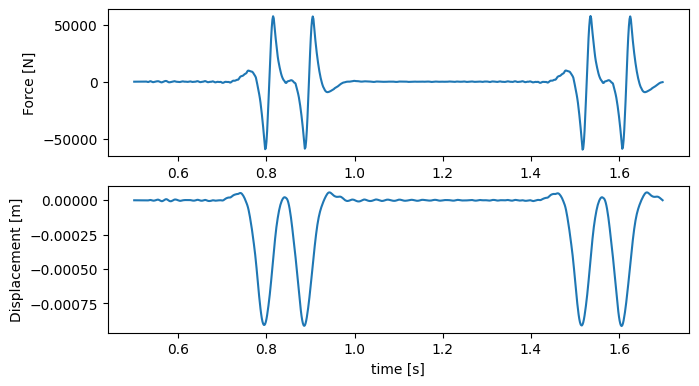

In [25]:
# plot vertical force and displacement of the rail at one node
fig, (ax1, ax2) = plt.subplots(2)

rail_node_nbr = 100
ax1.plot(time[:], vertical_force_rail[rail_node_nbr, :])
ax2.plot(time[:], vertical_displacements_rail[rail_node_nbr, :])

ax1.set_xlabel('time [s]')
ax1.set_ylabel('Force [N]')

ax2.set_xlabel('time [s]')
ax2.set_ylabel('Displacement [m]')

fig.set_size_inches(7.5,4.2)

plt.show()

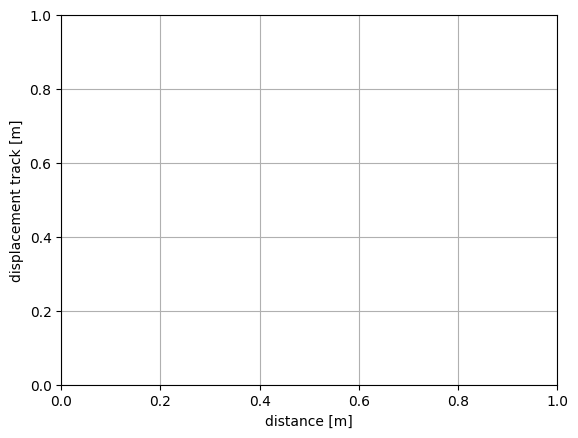

In [26]:
# create animation of the vertical force in the soil over time
animation_file_name = r"disp_track_animation.html"
vert_disp_rail = np.array(res_numerical['vert_disp_rail'])[:,first_calc_t_idx:]
coords_rail = np.array(res_numerical['coords_rail'])

create_animation(animation_file_name, (coords_rail),(vert_disp_rail),fps=60)

# Run cumulative settlement model
<img src="static/cumulative_settlement_model.png">

In [27]:
from rose.model.accumulation_model import Varandas, AccumulationModel

# load results
with open(os.path.join(output_dir, file_name), 'rb') as f:
    res_numerical = pickle.load(f)

# Set train time table information
Below the time table for one type of train is added

In [28]:
# set train information
train_info = {"dubbeldekker": {"forces": res_numerical['vertical_force_soil'], # add force in soil
                               "nb-per-hour": 6,                               # number of trains per hour
                               "nb-hours": 6,                                  # number of traffic hours per day
                               "nb-axles": 16}                                 # number of wheel axles per train
             }

# Calculate cumulative settlement

In [29]:
nb_days = 365
node_nb = 100

model = Varandas()
sett = AccumulationModel(accumulation_model=model)
sett.read_traffic(train_info, nb_days)
sett.calculate_settlement(idx=[node_nb])


Running Varandas model


100%|██████████| 210240/210240 [00:23<00:00, 9062.86it/s] 


In [30]:
# save results
sett_file_name = "settlement.json"
sett.write_results(os.path.join(output_dir, sett_file_name))

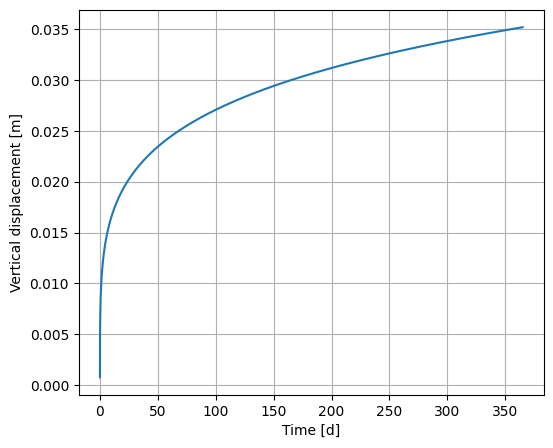

In [31]:
fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(sett.results["time"], sett.results["displacement"][0])
ax.grid()
ax.set_xlabel("Time [d]")
ax.set_ylabel("Vertical displacement [m]")
plt.show()